# Deep Learning Model Definition & Declaration

## 0. Recap

Before getting into defining deep learning models, let's recap what has already been done so far. The training data is already created and saved somewhere locally as `tfrecord` files. If not familar with the procedure of how the dataset is created, find the corresponding illustration [here](../dataset_management/dataset_generation.ipynb). Each file contains one sample of the market data, which is consist of:

1. history data: a matrix $H \in \mathbb{R}^{N \times 5}$ where $N$ is the number of consecutive candlesticks, and each row in the matrix has 5 numbers representing the normalized **open, high, low, close, volume** values of a certain time, in this specific order.

2. label data: the class label of the history data which is a single number $y \in \{1, 0, -1\}$, according to the [labelling method](https://towardsdatascience.com/financial-machine-learning-part-1-labels-7eeed050f32e) (**The triple-Barrier Method**) adopted when creating the dataset, 
    - $y=1$ represents that the price will penetrate the upper bound given the history data; 
    - whereas $y=0$ represents that the price will oscillate between the upper and lower bounds; 
    - and finally $y=-1$ means the price will go down to break the lower bound.

3. future data: a matrix $F \in \mathbb{R}^{T \times 5}$ where $T$ is the number of consecutive candlesticks, and this matrix represents what actually happened right after the history data and lasts for $T$ periods of time.

So for example, let's reconstruct the trading data back from one of the data files and see what's inside.

提示：当前环境 pandas 版本高于 0.25，get_price 与 get_fundamentals_continuously 接口 panel 参数将固定为 False
注意：0.25 以上版本 pandas 不支持 panel，如使用该数据结构和相关函数请注意修改
[INFO] 4701 files founded.

=== Data Information ===
[history] 
shape = (144, 5)
dtype=<dtype: 'float32'>

[label] 
shape = ()
dtype=<dtype: 'int64'>

[future] 
shape = (12, 5)
dtype=<dtype: 'float32'>

History data preview


,open,high,low,close,volume
0,0.998943,1.000765,0.998942,1.000000,1.000000
1,1.000046,1.001380,0.998978,1.000106,0.885683
2,1.000100,1.002428,0.999411,1.001307,0.950077
3,1.001307,1.005244,1.001307,1.004420,1.289511
4,1.004420,1.004732,1.002859,1.002859,0.542762
...,...,...,...,...,...
139,1.005257,1.005257,1.001664,1.002966,0.528022
140,1.002966,1.004584,1.001414,1.002300,0.603724
141,1.002095,1.004678,1.000252,1.003283,0.753686
142,1.003192,1.005589,1.002423,1.004274,0.874799



Future data preview


,open,high,low,close,volume
0,1.003856,1.004554,1.001906,1.002909,0.623357
1,1.002909,1.005827,1.002909,1.005295,0.698024
2,1.005366,1.006709,1.003272,1.003497,0.592024
3,1.003570,1.003911,1.002149,1.002257,0.437347
4,1.002257,1.002755,1.000658,1.001164,0.705134
5,1.001164,1.001164,0.997190,0.997630,0.750731
6,0.997630,1.000231,0.996957,0.998782,0.885473
7,0.998641,1.002108,0.998641,1.002108,0.661703
8,1.002107,1.003853,1.001627,1.003675,0.515657
9,1.003675,1.005318,1.001783,1.003855,0.687002


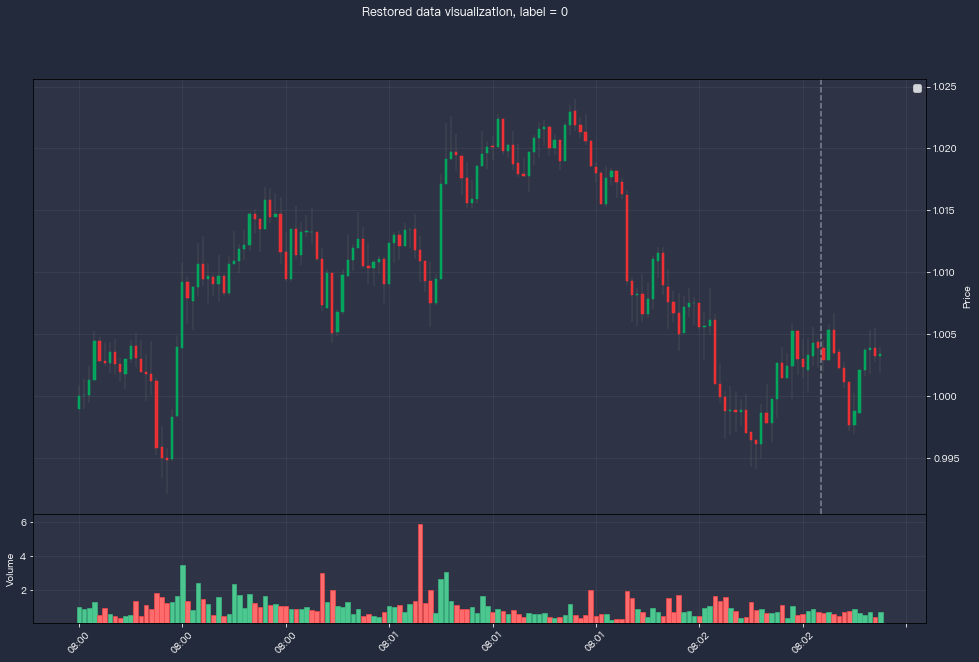

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from datetime import datetime
from pathlib import Path
import pandas as pd

_project_root = Path().cwd().parent
sys.path.append(str(_project_root))

from dataset_management.tools import load_dataset
from utilities.visualizations import mpf_draw_trading_data

train_dir = _project_root / 'dataset' / 'train'
valid_dir = train_dir.parent / 'valid'
dataset = load_dataset(valid_dir)

history, label, future = next(iter(dataset))

print("\n=== Data Information ===")
print(f"[history] \nshape = {history.shape}\ndtype={history.dtype}\n")
print(f"[label] \nshape = {label.shape}\ndtype={label.dtype}\n")
print(f"[future] \nshape = {future.shape}\ndtype={future.dtype}\n======\n")

N, T = len(history), len(future)

# create dataframes out of the data so that we can visualize them with the visualization module
history_df = pd.DataFrame(history.numpy(), columns=['open', 'high', 'low', 'close', 'volume'])
future_df = pd.DataFrame(future.numpy(), columns=['open', 'high', 'low', 'close', 'volume'])

print("History data preview")
display(history_df)
print("\nFuture data preview")
display(future_df)

df = pd.concat([history_df, future_df])
df.index = list(map(datetime.fromtimestamp, range(N + T)))
df.index.name = 'datetime'
fig, axes = mpf_draw_trading_data(df, title=f"Restored data visualization, label = {label.numpy()}", figsize=(16, 10))
axes[0].axvline(x=N-.5, alpha=.4, c='white', ls='--');

## 1. Intuitions

The main intuition of the model is from the technical indicators that traders across the world have been using for centuries, such as the **SMA, EMA, MACD, RSI** etc. After reading the definitions of those indicators, it is not hard to know that they are directly or indirectly derived from the original OHLCV data using various kinds of mathematical formula. And from a data scientist's perspective, all these indicators are similar to the results of the 1-dimensional convolutions with various kernels, or the convolution of the said convolutions.

For instance, the SMA indicator (a.k.a. MA) has a parameter specifying the number of closing prices need to be taken into account for computing the average value, and this is exactly what a 1-D convolution with kernel 
$k = 
\begin{bmatrix}
 \frac{1}{N} & \frac{1}{N} & ... & \frac{1}{N}
\end{bmatrix}, k \in \mathbb{R}^{N}$
 does, where $N$ is the SMA period.
 
And the **MACD** indicator is equivalent to the result of the combination of vectorized arithmetic operations and convolutions against the **SMA/EMA** derived from the OHLCV. 

This fashion of computations is very similar to the stacking of convolution layers in neural networks. Therefore in this work, a hypothesis is proposed that by constructing a convolutional neural network with 1-dimensional kernels, the model can learn to identify the underlying patterns which implies how the market price will oscillate in the near future, given the price movement history. 

## 2. Models

### 2.1 Fully Convolutional Network

The first architecture proposed is in a fully convolutional fashion. It does not require the input tensors to have the same shape, which means that the model learns to make predictions based on arbitrary lengths of history data.

In the architecture, there are several modules inspired from various image recognition networks which might be useful.

### 2.2 Inception Module

In image classification and object detection tasks, Inception has played a critical role in that it enables the network to capture both small and large object characteristics in an image by utilizing various sizes of kernels. Same idea can also be applied here in our task, as different receptive field sizes may reveal a rich set of underlying features inside a market price movement, just as do the technical indicators **MA5** and **MA20**.

The inception module modified to fit this task is defined using 1-dimensional convolutions instead of 2-dimensional, and a visual representation can be found in **Fig 1**.

| ![inception](../doc/assets/inception.png) |
|:---:|
|**Fig 1. (left) 1-D Inception Module; (right) Inception Module with dimension reduction**|

### 2.3 Residual Connections

It is widely accepted that as network goes deeper, training the network becomes more challenging. As a solution, the residual structure is introduced. Unlike the original residual blocks that is often used in image recognition tasks, only the idea of residual connections is directly added onto the inception module.

This also enables the network to learn the interactions between features generated from different layers, similar to the **MACD** indicator in that it subtracts the **DEA** from **DIF** where **DEA** is the **MA** of **DIF**, which in a sense is one layer deeper than the **DIF**.

The residual connection is added as shown in **Fig 2**. When the input and output tensor share the same number of channels, the residual connection is added as the left figure, whereas the output channels differ, the residual connection is shown on the right, where the input tensor goes through a projection convolution layer to transform the output channel to be equal to the inception output.

|![res-inception](../doc/assets/residual-inception.png)|
|:---:|
|**Fig 2. Inception Module with Residual Connections**|

The implementation of the Inception module with residual connections is as follows:

In [6]:
import tensorflow as tf
from tensorflow.python.keras.layers import BatchNormalization, ReLU, Concatenate, MaxPooling1D, Conv1D

from prototype.base_layers import ConvBn


class Inception(tf.keras.layers.Layer):
    def __init__(self, f_1: int, f_2: list, f_3: list, f_out: int, reduction: bool, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.params = dict(
            f_1=f_1,
            f_2=f_2,
            f_3=f_3,
            f_out=f_out,
            strides=2 if reduction else 1,
            reduction=reduction
        )

    def build(self, input_shape):
        self.bn_layer = BatchNormalization(scale=False)
        self.relu_layer = ReLU()
        self.concat_layer = Concatenate()

        self.conv1 = ConvBn(
            filters=self.params['f_1'],
            kernel_size=1,
            strides=self.params['strides'],
            name='incep1'
        )

        self.conv2 = [
            ConvBn(filters=self.params['f_2'][0], kernel_size=1, strides=self.params['strides'], name='incep2_1'),
            ConvBn(filters=self.params['f_2'][1], kernel_size=3, name='incep2_2')
        ]

        self.conv3 = [
            ConvBn(filters=self.params['f_3'][0], kernel_size=1, strides=self.params['strides'], name='incep3_1'),
            ConvBn(filters=self.params['f_3'][1], kernel_size=5, name='incep3_2')
        ]
        if self.params['reduction']:
            self.pool_layers = [
                MaxPooling1D(pool_size=3, strides=2, padding='same', name='incep4_pool'),
                ConvBn(filters=128, kernel_size=1, name='incep4_conv')
            ]
        self.conv_out = Conv1D(filters=self.params['f_out'], kernel_size=1, use_bias=False, name='out', padding='same')
        self.projection_layer = Conv1D(
            filters=self.params['f_out'], kernel_size=1, strides=2, use_bias=False, padding='same', name='projection')

    def call(self, input_tensor, **kwargs):
        layer_in = self.bn_layer(input_tensor)
        layer_in = self.relu_layer(layer_in)

        branch_outputs = [self.conv1(layer_in)]
        x = layer_in
        for layer in self.conv2:
            x = layer(x)
        branch_outputs.append(x)

        x = layer_in
        for layer in self.conv3:
            x = layer(x)
        branch_outputs.append(x)

        if self.params['reduction']:
            x = layer_in
            for layer in self.pool_layers:
                x = layer(x)
            branch_outputs.append(x)

        concat = self.concat_layer(branch_outputs)
        x = self.conv_out(concat)
        if self.params['reduction']:
            input_tensor = self.projection_layer(input_tensor)
        return x + input_tensor

Next, let's construct a simple FCN using the inception module implemented above. A visualization of the network is shown in **Fig 3.**

|![fcn](../doc/assets/fcn.png)|
|:---:|
|**Fig 3. FCN architecture**|

In [10]:
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling1D


def build_fcn(input_size):
    input_tensor = Input(shape=(input_size, 5), name='input')

    conv11 = ConvBn(filters=8, kernel_size=7, name='conv1_1')(input_tensor)
    conv12 = ConvBn(filters=16, kernel_size=3, name='conv1_2')(conv11)
    pool11 = MaxPooling1D(pool_size=3, strides=2, padding='same', name='pool1_1')(conv12)

    conv21 = ConvBn(filters=16, kernel_size=3, name='conv2_1')(pool11)
    conv22 = ConvBn(filters=32, kernel_size=3, name='conv2_2')(conv21)

    conv31 = Inception(f_1=32, f_2=[32, 64], f_3=[32, 48], f_out=64, reduction=True, name='conv3_1')(conv22)
    conv32 = Inception(f_1=32, f_2=[32, 64], f_3=[32, 48], f_out=64, reduction=False, name='conv3_2')(conv31)

    conv41 = Inception(f_1=32, f_2=[64, 96], f_3=[32, 64], f_out=128, reduction=True, name='conv4_1')(conv32)
    conv42 = Inception(f_1=32, f_2=[64, 96], f_3=[32, 64], f_out=128, reduction=False, name='conv4_2')(conv41)

    conv51 = Inception(f_1=64, f_2=[64, 192], f_3=[48, 128], f_out=256, reduction=True, name='conv5_1')(conv42)
    conv52 = Inception(f_1=64, f_2=[64, 192], f_3=[48, 128], f_out=256, reduction=False, name='conv5_2')(conv51)

    conv61 = Inception(f_1=64, f_2=[64, 192], f_3=[64, 128], f_out=384, reduction=True, name='conv6_1')(conv52)
    conv62 = Inception(f_1=64, f_2=[64, 192], f_3=[64, 128], f_out=384, reduction=False, name='conv6_2pre')(conv61)
    conv62 = BatchNormalization(scale=False, name='conv6_2bn')(conv62)
    conv62 = ReLU(name='conv6_2')(conv62)

    features = GlobalAveragePooling1D(name='features')(conv62)
    out = Dense(3, activation='softmax', name='prediction')(features)
    model = Model(input_tensor, out, name='FCN')
    return model


fcn = build_fcn(input_size=144)
fcn.summary()

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 144, 5)]          0         
_________________________________________________________________
conv1_1 (ConvBn)             (None, 144, 8)            312       
_________________________________________________________________
conv1_2 (ConvBn)             (None, 144, 16)           448       
_________________________________________________________________
pool1_1 (MaxPooling1D)       (None, 72, 16)            0         
_________________________________________________________________
conv2_1 (ConvBn)             (None, 72, 16)            832       
_________________________________________________________________
conv2_2 (ConvBn)             (None, 72, 32)            1664      
_________________________________________________________________
conv3_1 (Inception)          (None, 36, 64)            41888   

## 3. Future Possibilities

Aside from the simple FCN network defined above, one can also modify the architecture to experiment whatever modules suitable for the task, such as setting the input shape to a fixed number and apply width-wise fully connected layer to the last inception output (conv6_2) instead of global average pooling and dense layers, which applies channel-wise computations. 

Moreover, recurrent networks can be concatenated after the inceptions such as GRU and LSTM to enable the network to learn in a time-series fashion, which also makes sense here.